# Cleaning Data

<br>in this notebook we will clean data and unify job posts in order to get better analysis results <br>
data needs some further cleaning steps, the info extracted using ChatGPT is not ready to be used in our analysis <br>

Clening Steps will be as follow:

1. Clean **Job Title**:
   - remove hash sign from hashtags.
   - remove leading and trailing spaces.
   - remove useless punctuation.
   - unify job titles ex. `(reactjs , react-js, react js, react.js) -> react-js`.
   - getting higher level job title, ex. `ios developer -> mobile developer` and `laravel developer -> back-end developer`.
   - extract experience level from job title (senior, mid, junior).
2. Clean **Company Name**: remove punctuation and names that we know are not official names
3. Clean **Salary**:
   - remove non-salary values
   - normalize currencies
   - calculate average
4. Clean **Years of Experience**:
   - remove useless values
   - get average years needed
5. Clean **Job Type**:
6. Clean **Location**:
   - use spacy to extract location from string


In [1]:
import numpy as np
import pandas as pd
import re
from wordcloud import WordCloud
import spacy


In [2]:
# reading data
data = pd.read_csv("../data/data_v4.csv")
data.shape


(832, 17)

## Cleaning **Job Title**


In [3]:
data.job_title.nunique()


364

there's 364 unique job titles in dataset, we will try to reduce that number.


we will create a new column called _abstract_title_ , this is the normalized version of job_title


In [4]:
# craft position from the job post and remove it from the title

experience = data.job_title.apply(
    lambda x: np.nan
    if x is np.nan
    else "senior"
    if "senior" in x
    else "mid"
    if "mid" in x
    else "junior"
    if "junior" in x
    else np.nan
)
data["abstract_title"] = data.job_title.apply(
    lambda x: x.replace("senior", "").replace("junior", "").replace("mid", "").strip()
    if x is not np.nan
    else np.nan
)
print(data.abstract_title.nunique())


338


removing experience level from job title decreased unique job titles by 26 titles


Now, we will build a dictionary to group job titles that belongs to the same category, it means, when a `react.js` developer is needed, then the vacancy is actually a `front-end developer`, but the main skill is `react.js`.


In [5]:
def abstract_job_title(title):
    if title is np.nan:
        return title
    abstract_titles = {
        "full-stack": [
            "full stack",
            "fullstack",
            "full-stack",
            "(laravel + vue.js)",
            "(laravel+vue.js)",
            "flutter / laravel developer",
            "laravel and reactjs",
        ],
        "front-end": [
            "front end",
            "frontend",
            "front-end",
            "react js developer",
            "react.js developer",
            "reactjs developer",
            "vue.js developer",
            "vue developer",
            "front developer",
            "angular developers",
        ],
        "back-end": [
            "back end",
            "backend",
            "back_end",
            "back-end",
            "laravel developer",
            "laravel php developer",
        ],
        "ui/ux designer": ["ui/ux", "ux/ui", "ui ", "ui\\ux", "ui-ux"],
        ".net developer": [".net core developer", ".net developer", ".net server"],
        "mobile app developer": [
            "mobile app",
            "mobile ",
            "moobile app",
            "(mobile)",
            "flutter developer",
            "ios developer",
            "android developer",
        ],
        "motion designer": [
            "motion graphic designer",
            "video graphic designer",
            "motion graphics",
        ],
        "graphic designer": [
            "graphic designer",
            "graphic_designer",
            "graphic designers",
        ],
        "social media manager": [
            "social media",
            "youtube channels manger",
            "blog manager",
        ],
        "sales": ["sales"],
        "web developer": [
            "web developer",
            "web_developer",
            "web/app developer",
            "website developer",
            "_web_developer",
            "web designer",
            "web application developer",
            "web developers",
        ],
        "software developer": [
            "software developer",
            "software developers",
            "softwaredeveloper",
        ],
        "digital marketing": [
            "digital marketing manager",
            "digital marketer",
            "digital marketing executives",
            "manager of marketing",
            "marketing manager",
        ],
        "network and system administrator": [
            "network & system administrator",
            "network and system administrator",
            "network & systems administrator",
            "network and system auditor",
            "networks & servers specialist",
        ],
        "accountant": [
            "accounting manager",
            "accountant",
            "accountants",
            "chief accountant",
        ],
        "quality assurance": [
            "quality assurance",
            "software quality",
            "qa engineer",
            "software_qa_tester",
            "software qa tester",
            "software_manual_tester",
            "software_tester",
            "software test engineer",
            "qa tester",
        ],
        "human resources": [
            "hr officer",
            "hr specialist",
            "hr recruiter",
            "human_resources",
            "human resources",
        ],
        "content creator": ["content", "copy writer", "news editor"],
        "secretary": ["secretary"],
    }
    sub = title
    for k, v in abstract_titles.items():
        for kw in v:
            if kw in sub:
                sub = k
                # print(sub)
    return sub


In [6]:
data.abstract_title.apply(abstract_job_title).nunique()


174

In [7]:
data["abstract_title"] = data.abstract_title.apply(abstract_job_title)
data["experience_level"] = experience


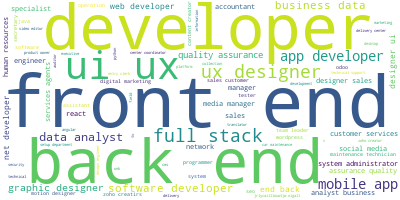

In [8]:
# creating word cloud to form a higher understanding of titles
long_string = ",".join(
    list(
        data.loc[data.abstract_title.notna()]
        .abstract_title.apply(abstract_job_title)
        .values
    )
)

wordcloud = WordCloud(
    background_color="white", max_words=5000, contour_width=3, contour_color="steelblue"
)

wordcloud.generate(long_string)

wordcloud.to_image()


as the word cloud shows, **front-end** , **back-end**, **ui-ux designer** and **full-stack** are the most significant keywords in job posts title <br>

we can see also keywords such as software developer, graphic designer, and mobile app.


## Cleaning **Company Name** column


In [9]:
print(f"Number of non empty Company Names: {data.company_name.notna().sum()}")
print(f"Number of Unique Company Names: {data.company_name.nunique()}")


Number of non empty Company Names: 693
Number of Unique Company Names: 263


In [10]:
def fix_company_name(text):
    if text is np.nan:
        return text

    text = re.sub(r"#|(tawasol(_job)?)|none", "", text)
    text = text.lower().strip()

    return text


data.company_name.apply(fix_company_name).nunique()


261

In [11]:
data.company_name = data.company_name.apply(fix_company_name)


we cannot do much in here because company names are **Named Entities** so it can take any value, especially when we are analyzing job posts in an Arabian market, arabic company names can be bizzar. <br>
but using simple operations we managed to decrease the unique names from 301 to 258


## Fixing Salary Column


salary is one of the hardest columns to clean and extract actual salaries.
data in this column can take multiple forms, and ChatGPT didn't do well in extracting this info, here is an example of the challenges I faced when trying to clean this column:

- no currency clue : starting from 1.5 million
- no useful numbers: good, competitive, to be defined after the interview, negotiable
- written values: 3.5-7 million syp
- range with no currency: 500-700
- different abbreviations: syp, s.p, sp., syrian lirra, syrian pound, l.s
- non salary values: +905528888787


after multiple attempts to fix this column, I managed to reach a good format for all values.


In [12]:
def fix_salary(salary):
    if salary is np.nan:
        return salary

    if not re.search("\d+", salary):
        return np.nan

    salary = re.sub(r"syp|sp|l\.s|syrian lira|syrian pound(s)?|s\.p", " SYP", salary)
    salary = re.sub(r"dollar|usd|\$|\ds$", " USD", salary)
    salary = re.sub(r"(\d\.\d)(\s?million)", r"\1.00000", salary)
    salary = re.sub(r",|#|~|'|:|\.", "", salary)
    salary = re.sub(r" million(s)?|(?<=\d)m", "000000", salary)
    salary = re.sub(r"(?<=\d)\s+(?=\d{3}\s)", "", salary)
    salary = re.sub(r"per month|starting from|up to", "", salary)
    salary = salary.strip()
    salary = re.sub(r"(?<=0{3})$", " SYP", salary)
    salary = re.sub(r"(?<=0{2})$", " USD", salary)
    salary = re.sub(r"SYP\s+", "", salary)
    salary = re.sub("to|-|/", " - ", salary)
    salary = re.sub(r"\s+", " ", salary)
    salary = re.sub(r"(?<=^\d{2})\s(?=-)", "00000 ", salary)
    salary = re.sub(r"(?<=^\d{1})\s(?=-)", "000000 ", salary)

    if "SYP" not in salary and "USD" not in salary:
        return np.nan

    match = re.findall("\d+", salary)
    if "SYP" in salary:
        for item in match:
            if int(item) < 100000:
                salary = np.nan
                break

    if "USD" in match:
        for item in match:
            if int(item) > 10000:
                salary = np.nan
                break

    if match and len(match) > 2:
        salary = np.nan

    return salary


In [13]:
data.salary = data.salary.apply(fix_salary)
print(data.salary.nunique())


24


In [14]:
def calculate_avg_salary(text):
    if text is np.nan:
        return text

    match = re.findall("\d+", text)
    is_dollar = re.search("USD", text) is not None
    if match:
        if len(match) > 1:
            return int((int(match[0]) + int(match[1])) / 2 * (6000 if is_dollar else 1))
        return int(match[0]) * (6000 if is_dollar else 1)


In [15]:
data["avg_salary"] = data.salary.apply(calculate_avg_salary)


## Fixing location column

we will use spacy library to detect location named entities from text


In [16]:
data.location.nunique()


84

In [17]:
nlp = spacy.load("en_core_web_sm")


In [18]:
def extract_location(location):
    if location == np.nan:
        return location
    loc = ""

    if "remote" in location:
        loc = "remotely"

    doc = nlp(location)
    for ent in doc.ents:
        if ent.label_ == "GPE":
            if loc == "remotely":
                loc = "(hybrid) remotely"
            loc += " " + ent.text

    return loc.strip().lower()


In [19]:
data.location = data.location.astype("str").apply(extract_location)


In [20]:
def fix_location(text):
    if text is np.nan:
        return text
    text = re.sub("adnan|qassa", "", text)
    text = re.sub(
        "damascus syria syria|damascus syria|syria damascus|damascus",
        "Damascus - Syria",
        text,
    )
    return text.strip()


data.location = data.location.apply(fix_location)


In [21]:
data.location.nunique()


15

### Fixing Years of Experience column


this was a challenging column as well, it contains multiple formats and values.


In [22]:
data.years_of_experience.nunique()


133

In [23]:
def fix_experience_years(text):
    if text is np.nan:
        return text
    numbers = {
        "one ": "1 ",
        "two ": "2 ",
        "three": "3",
        "four ": "4 ",
        "five ": "5 ",
        "six ": "6 ",
        "seven ": "7 ",
        "eight ": "8 ",
        "nine ": "9 ",
        "ten ": "10 ",
    }
    numbers_re = re.compile("|".join(numbers.keys()))

    text = numbers_re.sub(lambda x: numbers[x.group()], text)
    text = re.sub("fresh ", "0 year", text)

    if not re.search("\d", text):
        return np.nan

    match = re.findall(r"\b\d+\b", text)
    if match:
        numbers_set = np.array(list(set(match)), dtype="int32")
        return np.floor(numbers_set.mean())
    return np.nan


In [24]:
data["avg_exp_years"] = data.years_of_experience.apply(fix_experience_years)


In [25]:
data.avg_exp_years.nunique()


12

### Fixing Job Type column


In [26]:
data.job_type.nunique()


90

In [27]:
def fix_job_type(text):
    if text is np.nan:
        return text

    text = text.lower().strip()
    text = re.sub(r"#|_", "", text)
    text = re.sub(r"(full time)|(fulltime)|(full_time)", "full-time", text)
    text = re.sub(r"(part time)|(parttime)|(part_time)", "part-time", text)

    res = ""
    if "full-time" in text:
        res += "full-time "
    if "part-time" in text:
        res += "part-time "
    if "freelance" in text:
        res += "freelance"
    if "train" in text:
        res += "training "
    if "free time" in text or "task bas" in text:
        res += "task based "

    if res == "":
        return np.nan

    return res.strip()


In [28]:
data["job_type"] = data.job_type.apply(fix_job_type)


In [29]:
data.job_type.nunique()


7

In [30]:
data.to_csv("../data/data_v5.csv", index=False)


## Summing UP


In [40]:
dirty = pd.read_csv("../data/data_v4.csv")
cleaned = pd.read_csv("../data/data_v5.csv")


## Conclusion

in this notebook we applied several cleaning steps on our data and that resulted in the following:

- **abstract_title** column was created
- **experience_level** column was created with following values (senior, mid, junior)
- **avg_experience_years** column was created
- **company_name, salary, location, job_type** columns were cleaned inplace
- **job_title, years_of_experience and skills** are still the same


now we can proceed to our data visualization step.
